# Scraping Central Regulation Website with Beautiful Soup Package
List of contents
- [Data Understanding](#data_understanding)
- [Data Gathering](#data_gathering)
- [Data Processing](#data_processing)
- [Data Visualization](#data_visualization)

### Reference
- [Towards Data Science](https://towardsdatascience.com/how-to-web-scrape-with-python-in-4-minutes-bc49186a8460)
- [Data Quest](https://www.dataquest.io/blog/web-scraping-beautifulsoup/)

In [1]:
# Import package for data gathering
import requests
import urllib.request
import time
import re
import math
from bs4 import BeautifulSoup

from IPython.core.display import clear_output
from time import sleep
from random import randint
from warnings import warn

# Import package for processing data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##  <a id='data_understanding_csv'>Data Understanding</a>

In [2]:
# Call the link that list all central regulation (Type: UU + PERPPU + PP + PERPRES)
url = 'http://peraturan.go.id/peraturan/index-lembaran-negara.html?LembaranNegaraSearch%5Bjenis_peraturan_id%5D=&LembaranNegaraSearch%5Bnomor%5D=&LembaranNegaraSearch%5Btahun%5D=&LembaranNegaraSearch%5Btentang%5D=&page=1'
response = requests.get(url)

In [3]:
response #200 means it went through

<Response [200]>

In [4]:
# Parse the website with BS4 package
soup = BeautifulSoup(response.text, "html.parser")

# Get the text
regulation_soup_text = soup.get_text()

In [5]:
# The number refers to total amount of regulation that exists sit beside "Data Peraturan" word
# Find index (backward)
index = regulation_soup_text.rfind("Data Peraturan") 

# Extract the total amount of existing regulation in the text
i=2
while regulation_soup_text[index-i:index-1].isdigit(): #stop when string is not digit anymore
    total = regulation_soup_text[index-i:index-1]
    i=i+1
        
# Existing regulation amount
print("total central regulation: ",total) #type str 

# Determine pages amount
total_page = math.ceil(int(total)/20) 
print("total page: ",total_page)

total central regulation:  8569
total page:  429


## <a id='data_gathering'>Data Gathering</a>

In [8]:
# Provide empty list to store scraped data
numbers = []
names = []
descriptions = []

# Preparing the monitoring for the loop
start_time = time.time()
requests_count = 0

for page in range(total_page):
    # Make a get request
    url = 'http://peraturan.go.id/peraturan/index-lembaran-negara.html?LembaranNegaraSearch%5Bjenis_peraturan_id%5D=&LembaranNegaraSearch%5Bnomor%5D=&LembaranNegaraSearch%5Btahun%5D=&LembaranNegaraSearch%5Btentang%5D=&page='+str(page+1)
    response = requests.get(url)
    
    # Pause the loop
    sleep(randint(8,15))
    
    # Monitor request
    requests_count += 1
    elapsed_time = time.time() - start_time
    print('Request: {}; Frequency: {} requests/s'.format(requests_count, requests_count/elapsed_time))
    clear_output(wait = True)
    
    # Throw a warning for non-200 status codes
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests_count, response.status_code))

    # Break the loop if the number of requests is greater than expected
    if requests_count > 429:
        warn('Number of requests was greater than expected.')
        break
    
    # Parse the content of the request with BeautifulSoup
    soup = BeautifulSoup(response.text, "html.parser")
    
    # Select everything inside the table
    regulation_table = soup.findAll('td')
    
    # Repeat scraping in every row
    for i in range(len(regulation_table)):
        if i%4==0: #Table number (used for double check)
            number = regulation_table[i].text
            numbers.append(number)
        if i%4==1: #Regulation title
            name = (regulation_table[i].text)
            names.append(name)
        if i%4==2: #Regulation short description
            description = (regulation_table[i].text)
            descriptions.append(description)
    

Request: 429; Frequency: 0.06922447224805618 requests/s


In [9]:
#gather scraped information into dataframe
regulation_df = pd.DataFrame({'no': numbers,
                              'title': names,
                              'about': descriptions,
                                })
print(regulation_df.info())
regulation_df.tail(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8569 entries, 0 to 8568
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   no      8569 non-null   object
 1   title   8569 non-null   object
 2   about   8569 non-null   object
dtypes: object(3)
memory usage: 201.0+ KB
None


,no,title,about
8559,8560,PERPPU NO. 8 TAHUN 1946,BADAN PERWAKILAN RAKYAT DI DAERAH SURAKARTA
8560,8561,PERPPU NO. 9 TAHUN 1946,PENCABUTAN PERPU TAHUN 1946 NOMOR 3 DAN PERUBA...
8561,8562,PERPPU NO. 10 TAHUN 1946,PENCABUTAN MENGALIRNYA UANG LAMA KE DAERAH LUA...
8562,8563,UU NO. 3 TAHUN 1946,PERATURAN TENTANG WARGA NEGARA DAN PENDUDUK NE...
8563,8564,PP NO. 1 TAHUN 1945,TENTANG DAN MULAI BERLAKUNJA UNDANG-UNDANG DAN...
8564,8565,UU NO. 1 TAHUN 1945,PERATURAN MENGENAI KEDUDUKAN KOMITE NASIONAL D...
8565,8566,PP NO. 2 TAHUN 1945,HA; MASIH TETAP BERLAKUNYA SEGALA BADAN-BADAN ...
8566,8567,PP NO. 3 TAHUN 1945,PERATURAN TENTANG PEMBERIAN AMPUN KEPADA ORANG...
8567,8568,PERPRES NO. 127 TAHUN 221,TUNJANGAN KINERJA PEGAWAI DI LINGKUNGAN KEMEN...
8568,8569,PERPRES NO. 20 TAHUN 39,PENGGUNAAN TENAGA KERJA ASING


In [10]:
regulation_df.to_csv('./database_peraturan.csv',index=False) #save scraped dataframe

## <a id='data_processing'>Data Processing</a>

In [2]:
regulation_df_load = pd.read_csv('./database_peraturan.csv') #load scraped dataframe

In [3]:
print(regulation_df_load)

        no                      title  \
0        1        PP NO. 1 TAHUN 2020   
1        2        PP NO. 2 TAHUN 2020   
2        3   PERPRES NO. 1 TAHUN 2020   
3        4   PERPRES NO. 2 TAHUN 2020   
4        5        PP NO. 3 TAHUN 2020   
...    ...                        ...   
8564  8565        UU NO. 1 TAHUN 1945   
8565  8566        PP NO. 2 TAHUN 1945   
8566  8567        PP NO. 3 TAHUN 1945   
8567  8568  PERPRES NO. 127 TAHUN 221   
8568  8569    PERPRES NO. 20 TAHUN 39   

                                                  about  
0                PENYELENGGARAAN KAWASAN EKONOMI KHUSUS  
1     JENIS DAN TARIF ATAS JENIS PENERIMAAN NEGARA B...  
2     PENGESAHAN MARRAKESH TREATY TO FACILITATE ACCE...  
3     PENGESAHAN BEIJING TREATY ON AUDIOVISUAL PERFO...  
4     PERUBAHAN ATAS PERATURAN PEMERINTAH NOMOR 14 T...  
...                                                 ...  
8564  PERATURAN MENGENAI KEDUDUKAN KOMITE NASIONAL D...  
8565  HA; MASIH TETAP BERLAKUNYA SEGALA BAD

In [4]:
# Extract regulation year and type that has already published by Indonesia on national level
regulation_df_load['type']=np.nan
regulation_df_load['year']=np.nan

#
# Expensive looping algorithm (Would be nice to know alternative way)
#
for i in range(len(regulation_df_load)): 
    
    #Regulation title contain type (UU/PERPRES/PP/PERPPU) in the first chunk of string
    regulation_df_load['type'][i]=regulation_df_load['title'][i].split()[0]
    
    # Most of the regulation title contain year in the fourth chunk of string
    # Some inconsistent title contain it in the fifth chunk
    if regulation_df_load['title'][i].split()[4]=="TAHUN":
        regulation_df_load['year'][i]=int(regulation_df_load['title'][i].split()[5])
    else:
        regulation_df_load['year'][i]=int(regulation_df_load['title'][i].split()[4])

C:\Users\juliv\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\juliv\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\juliv\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [5]:
# Irregular regulation title example
# Its type PERPRES is repeated twice
print(regulation_df_load["title"][2444])

# Regular regulation title example
print(regulation_df_load["title"][0])

PERPRES NO. PERPRES 17/2010 TAHUN 2010
PP NO. 1 TAHUN 2020


In [5]:
# Count the regulation that share same year and same type
total = regulation_df_load.groupby(["year", "type"]).size().reset_index(name="value")

# Convert long format into wide format
wide_total = total.pivot(index='year',columns='type',values='value')
wide_total = wide_total.fillna(0)

In [6]:
wide_total.head()

type,PERPPU,PERPRES,PP,UU
year,,,,
39.0,0.0,1.0,0.0,0.0
221.0,0.0,1.0,0.0,0.0
1945.0,0.0,0.0,3.0,1.0
1946.0,10.0,0.0,11.0,24.0
1947.0,0.0,0.0,26.0,41.0


In [9]:
# It was found out that there is error in the website itself. 
# Indonesia being independent in 1945 so any year earlier than that would be impossible.
wide_total = wide_total.drop([39,221])
wide_total.head()

type,PERPPU,PERPRES,PP,UU
year,,,,
1945.0,0.0,0.0,3.0,1.0
1946.0,10.0,0.0,11.0,24.0
1947.0,0.0,0.0,26.0,41.0
1948.0,0.0,0.0,79.0,35.0
1949.0,3.0,0.0,32.0,12.0


## <a id='data_visualization'>Data Visualization</a>

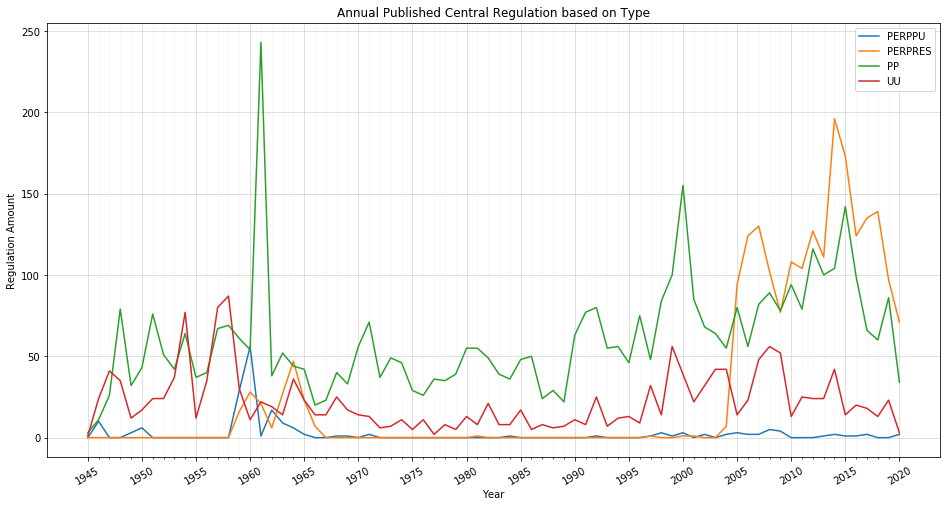

In [11]:
#plot published regulation based on type
fig=plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,1,1)

#set major ticks every 5 years and minor every year
major_ticks = np.arange(1945, 2021, 5)
minor_ticks = np.arange(1945, 2021, 1)

#plot results
ax.plot(wide_total)

#add ticks
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

#add grid
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.5)

#Add description
plt.title("Annual Published Central Regulation based on Type")
plt.xlabel("Year")
plt.ylabel("Regulation Amount")
plt.gca().legend(("PERPPU","PERPRES","PP","UU")) # Manually assign the legend

#rotate axis ticks label
plt.xticks(rotation=30)

fig.savefig('./Annual Published Central Regulation Categorically.png')

plt.show()

In [12]:
year_count = regulation_df_load['year'].value_counts(sort=False) # Count unique year value
year_count = year_count.sort_index() # Sort indexing year
year_count = year_count.drop([39,221]) # Drop the anomaly year

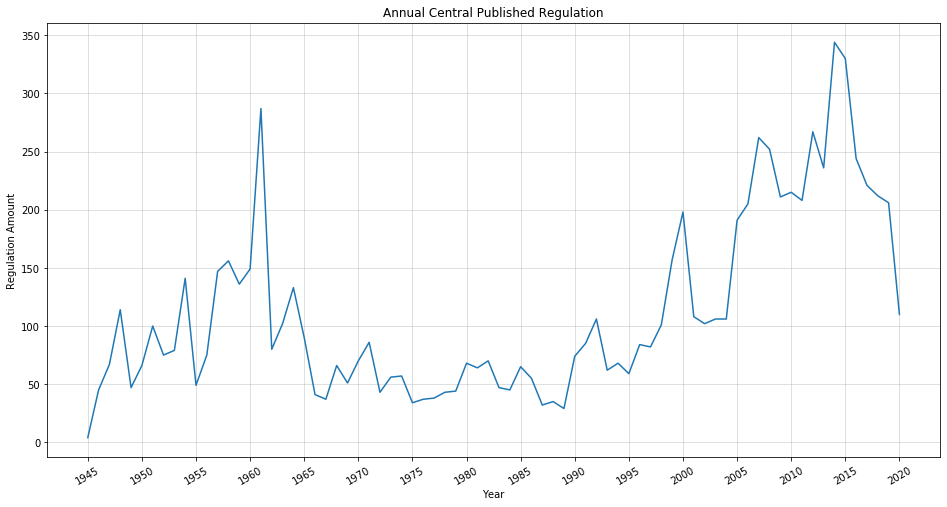

In [14]:
# Plot annual published regulation
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,1,1)

# Set major ticks every 5 years
major_ticks = np.arange(1945, 2021, 5)
ax.set_xticks(major_ticks)

# Add grid
ax.grid(which='major', alpha=0.5)

# Add description (title, axis label, and ordinate label)
plt.title("Annual Central Published Regulation")
plt.xlabel("Year")
plt.ylabel("Regulation Amount")

# Rotate axis ticks label
plt.xticks(rotation=30)

# Plot results
ax.plot(year_count)

fig.savefig('./Total Annual Central Published Regulation.png')

plt.show()